In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import multivariate_normal
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import lines
os.sys.path.append('../data/scripts/')
os.sys.path.append('../evaluation/')
from create_training_data_lib import random_mixture_sample, correlation_to_covariance, plot_cov_ellipse


In [2]:
# sample from random Gaussian mixture
sample, mean_vectors, std_devs, corr_mats, comps, sizes = random_mixture_sample(
    n_dimensions = 2,
    n_components = 2,
    n_samples = 3000,
    p_frac_range = [0.3, 0.3],
    quantize_step = np.random.choice([0, 0.05, 0.1, 0.2]),
)
cov_mats = [correlation_to_covariance(i,j) for i,j in zip(corr_mats, std_devs)]

# standardize
a = 1/sample.std(axis=0) # reciprocal of sample std for scaling
b = -sample.mean(axis=0) # negative of sample mean for shifting
std_devs = [i*a for i in std_devs]
mean_vectors = [a*(i+b) for i in mean_vectors]
sample = (sample+b)*a
del a, b


In [3]:
# predict NN

model_path = '../modeling/2d/'

os.sys.path.append(model_path)
os.sys.path.append(model_path+'/model/')
from predict import extract_features
os.sys.path.append('../evaluation/')
from metrics import output_to_stats_2d

# load model
model = tf.keras.models.load_model(model_path+'/model/model_checkpoint')
scalery = pickle.load(open(model_path+'/model/model_y_scaler.pkl', 'rb'))

# extract features
features = extract_features(sample)
features = features[np.newaxis, ..., np.newaxis]

# predict
p_nn = model.predict(features)
p_nn = scalery.inverse_transform(p_nn) # scale outputs
p_nn = output_to_stats_2d(p_nn[0])
p_nn


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1/1 [==============================] - 5s 5s/step


(array([ 0.09868655, -0.15476768], dtype=float32),
 array([[0.35582986, 0.2210012 ],
        [0.2210012 , 0.42850509]]))

In [4]:
def plot_mixture(means, stds, corr_mats, sample, plot_path=True):
    """ Plots pdfs of a simulated mixture distribution
    """
    
    # define grid for plotting pdf heat map
    x_grid, y_grid = np.mgrid[-4 : 4 : 100j, -4 : 4 : 100j,]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    colors_ellipses = ['blue', 'red', 'red']

    # calculate cov mats
    cov_mats = [correlation_to_covariance(i,j) for i,j in zip(corr_mats, stds)]

    # loop components and plot pdfs
    for i in range(len(means)):
        
        if not plot_path:
            if i>0:
                continue
                
        pdf = multivariate_normal(means[i], cov_mats[i]).pdf(positions).reshape(x_grid.shape)
        pdf = (pdf-pdf.min())/(pdf.max()-pdf.min())
        pdf[pdf<=0.01] = np.nan # no color for very low probability
        
        if i==0:
            plt.pcolormesh(x_grid, y_grid, pdf, cmap='Blues')
        else:
            plt.contour(x_grid, y_grid, pdf, levels=5, cmap='Reds', alpha=0.5)
            
#         ellipse = plot_cov_ellipse(
#             means[i], 
#             cov_mats[i],
#             facecolor='none',
#             edgecolor=colors_ellipses[i],
#             zorder=10
#         )
#         plt.gca().add_patch(ellipse)

def plot_prediction(mean, cov_mat):
    """ Plots pdfs of a simulated mixture distribution
    """
    
    # define grid for plotting pdf heat map
    x_grid, y_grid = np.mgrid[-4 : 4 : 100j, -4 : 4 : 100j,]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
    colors_ellipses = ['blue', 'red', 'red']
                
    pdf = multivariate_normal(mean, cov_mat).pdf(positions).reshape(x_grid.shape)
    pdf = (pdf-pdf.min())/(pdf.max()-pdf.min())
    pdf[pdf<=0.01] = np.nan # no color for very low probability

    plt.pcolormesh(x_grid, y_grid, pdf, cmap='Blues')

#         ellipse = plot_cov_ellipse(
#             means[i], 
#             cov_mats[i],
#             facecolor='none',
#             edgecolor=colors_ellipses[i],
#             zorder=10
#         )
#         plt.gca().add_patch(ellipse)
    
def extract_features(data):
    '''
    Function for extracting features from 2d inputs
    
    Arguments:
        data:      2D numpy array (samples, features)
    Returns:
        features:  feature vector
    '''
    
    # ensure correct shape
    data = data.squeeze()
    assert data.shape[1]==2, 'Error: input data is not 2D'
    
    # check for standardized data
    assert all([np.abs(0-i)<1e-2 for i in data.mean(axis=0)]), 'Error: data not standardized'
    assert all([np.abs(1-i)<1e-2 for i in data.std(axis=0)]), 'Error: data not standardized'
    
    # extract features
    fgridrng = (-3, 3)
    fgridpts = 50
    features = np.histogram2d(data[:,0], data[:,1], np.linspace(fgridrng[0], fgridrng[1], fgridpts+1), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features
                
        

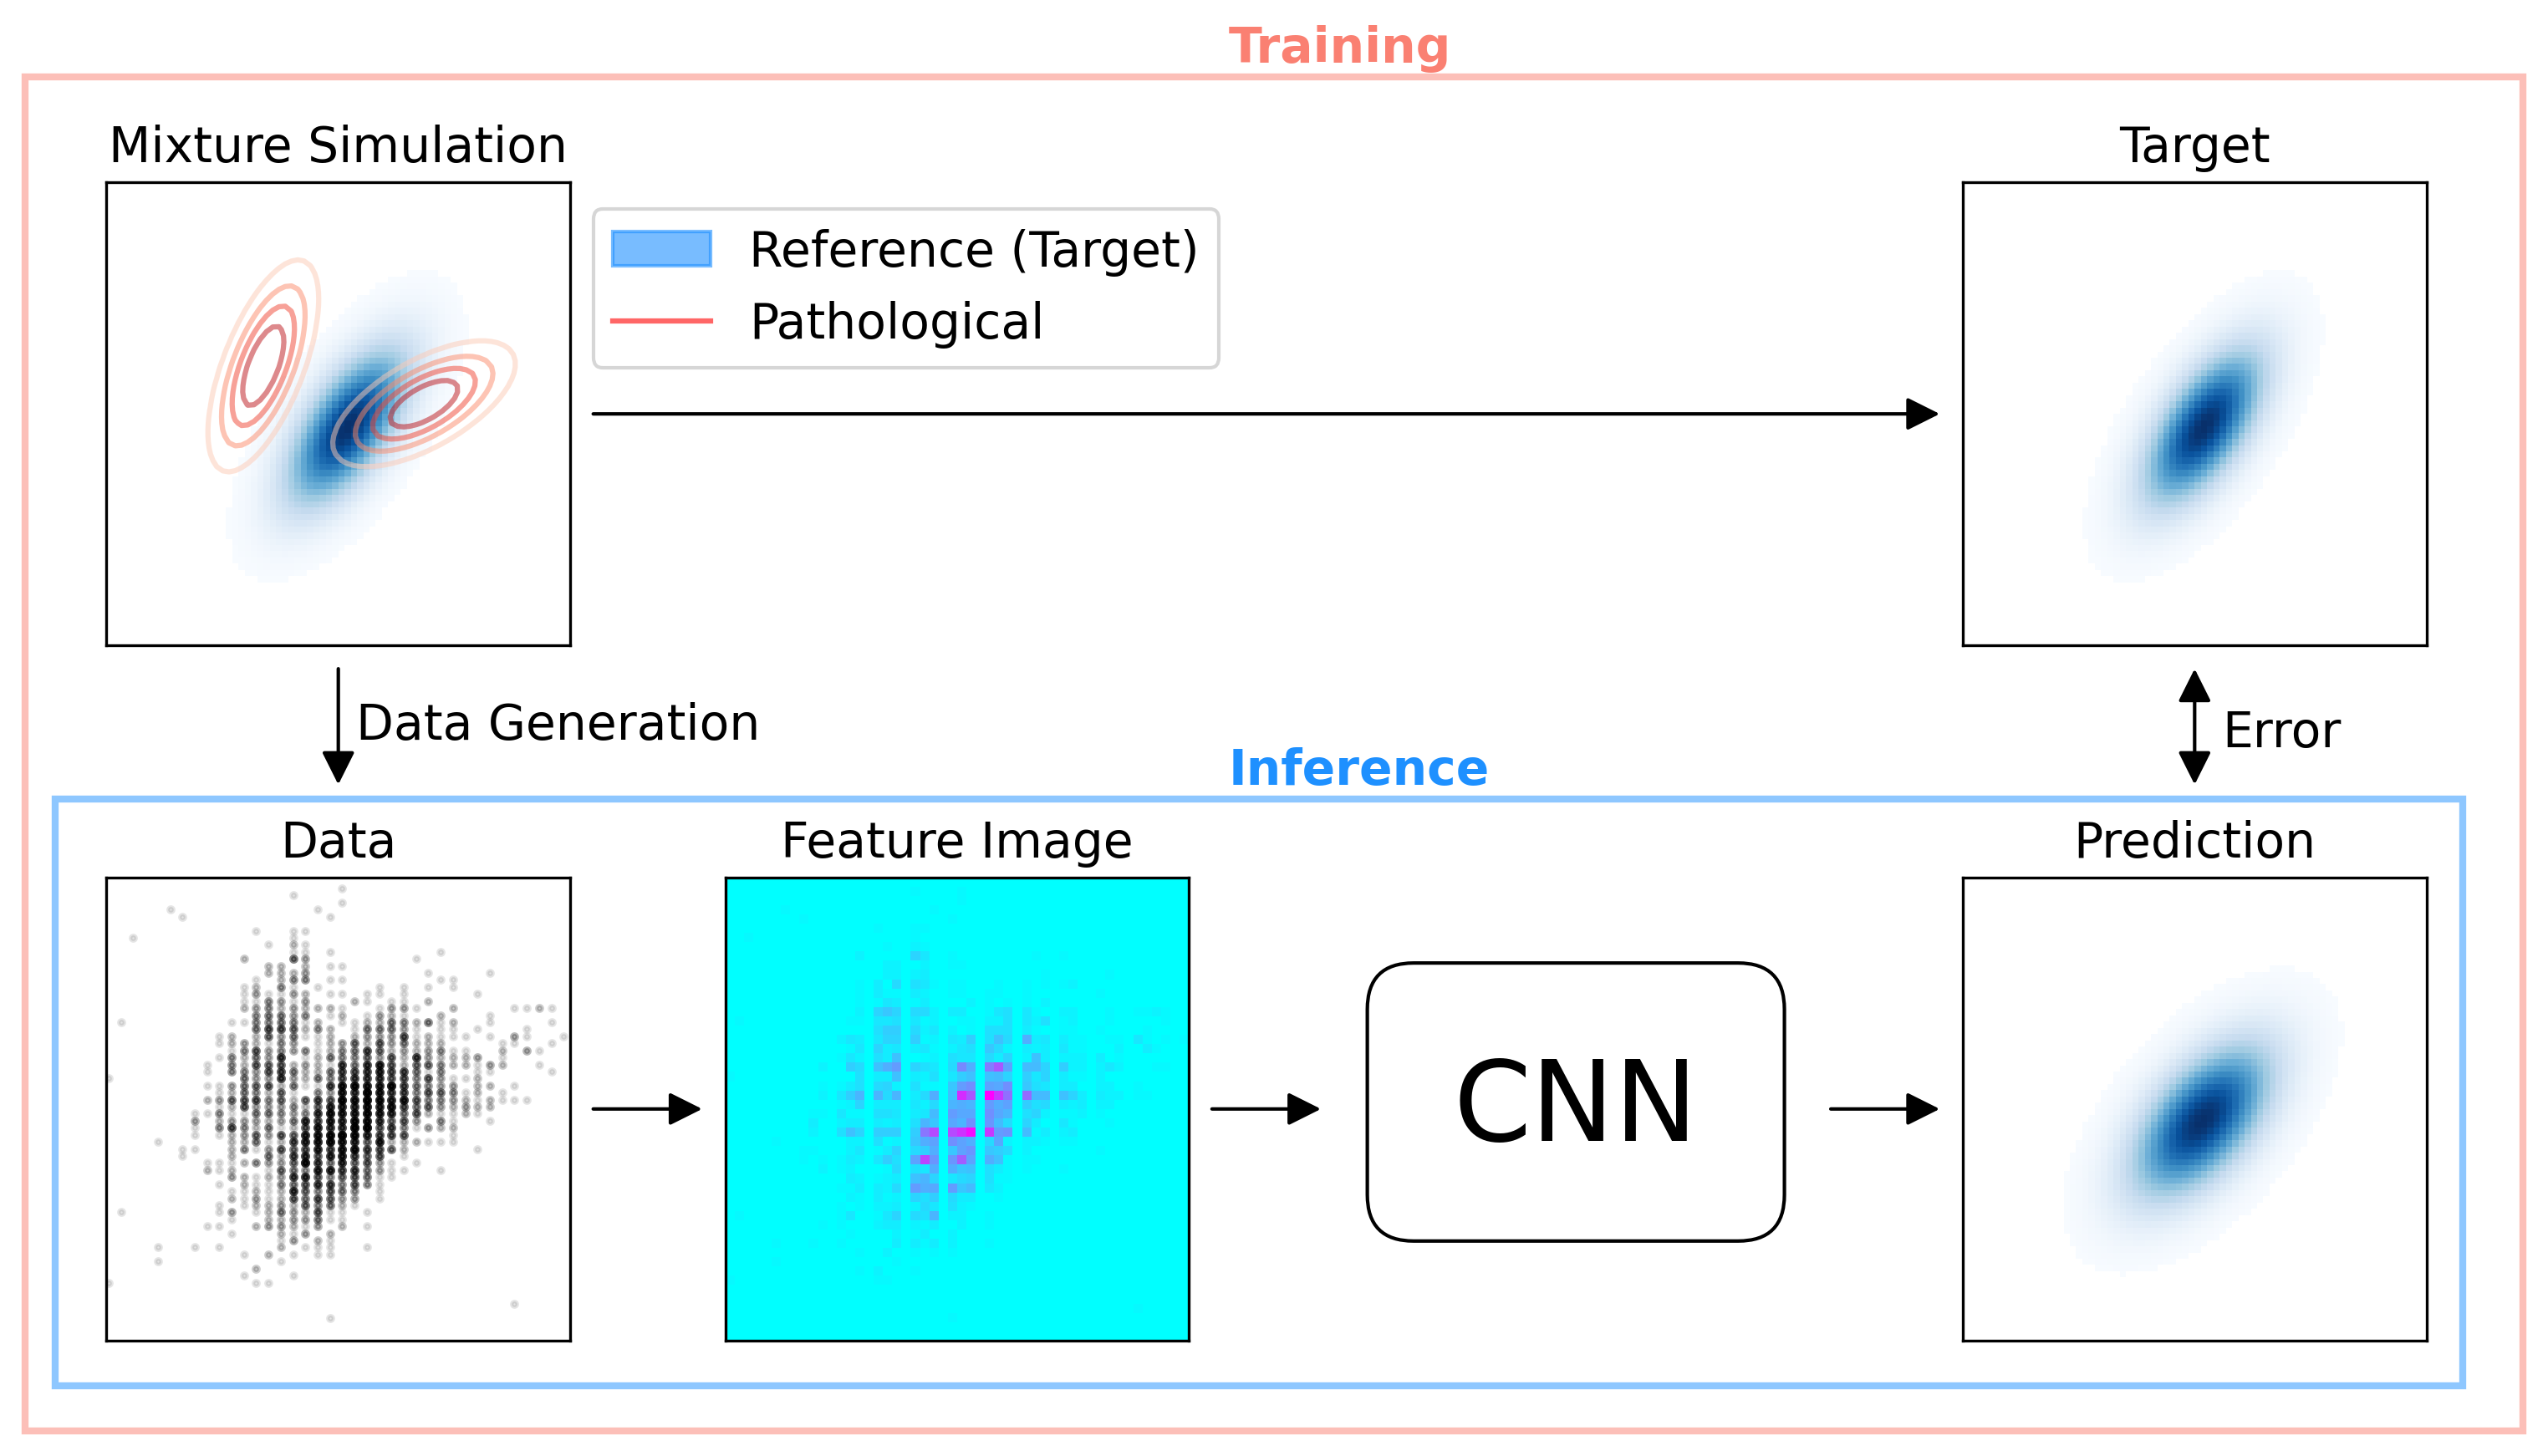

In [20]:
nc = 4

fs = 14
size = 3
lims = [-3, 3]
fig = plt.figure(figsize=(size*nc, size*2), dpi=300)

axes = []
# sample scatter plot
ax1 = plt.subplot(2, nc, nc+1, aspect='equal')
plt.scatter(sample[:,0], sample[:,1], s=10, marker='.', c='k', alpha=0.1)
plt.xticks([])
plt.yticks([])
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.title('Data', fontsize=fs)
axes.append(ax1)
plt.xlim(lims)
plt.ylim(lims)

# histogram image
ax2 = plt.subplot(2, nc, nc+2, aspect='equal')
plt.pcolormesh(extract_features(sample).T, cmap='cool')
plt.xticks([])
plt.yticks([])
plt.title('Feature Image', fontsize=fs)
axes.append(ax2)

# model
ax3 = plt.subplot(2, nc, nc+3, aspect='equal')
plt.gca().axis("off")
plt.gca().text(0.5, 0.5, 'CNN', fontsize=32, horizontalalignment='center', verticalalignment='center')
# add a fancy box
fancybox = patches.FancyBboxPatch(
    (0.15, 0.315), 0.7, 0.4,
    facecolor='none', edgecolor='k', 
    boxstyle=patches.BoxStyle("Round", pad=0.1))
ax3.add_patch(fancybox)
axes.append(ax3)

# output
ax4 = plt.subplot(2, nc, nc+4, aspect='equal')
plot_prediction(p_nn[0], p_nn[1])
plt.xticks([])
plt.yticks([])
plt.title('Prediction', fontsize=fs)
axes.append(ax4)
plt.xlim(lims)
plt.ylim(lims)

# sample mixture distributions
ax5 = plt.subplot(2, nc, 1, aspect='equal')
plot_mixture(mean_vectors, std_devs, corr_mats, sample)
axes.append(ax5)
plt.xlim(lims)
plt.ylim(lims)
plt.xticks([])
plt.yticks([])
plt.title('Mixture Simulation', fontsize=fs)
# legend
plt.gca().add_patch(patches.Rectangle((0, 0), 0, 0, color='dodgerblue', alpha=0.6, label='Reference (Target)'))
plt.gca().add_line(lines.Line2D([0, 0], [0, 0], color='red', alpha=0.6, label='Pathological'))
plt.legend(loc=(1.05, 0.6), fontsize=fs)

# target
ax6 = plt.subplot(2, nc, 4, aspect='equal')
plot_mixture(mean_vectors, std_devs, corr_mats, sample, plot_path=False)
plt.xticks([])
plt.yticks([])
plt.title('Target', fontsize=fs)
axes.append(ax6)
plt.xlim(lims)
plt.ylim(lims)

# arrows

# bottom row
for i in range(3):
    arrow = patches.ConnectionPatch(
        [1.05, 0.5],
        [-0.05, 0.5],
        coordsA=axes[i].transAxes,
        coordsB=axes[i+1].transAxes,
        color="black",
        arrowstyle="-|>",  # "normal" arrow
        mutation_scale=20,  # controls arrow head size
        linewidth=1,
    )
    fig.patches.append(arrow)
    
# top row
arrow = patches.ConnectionPatch(
    [1.05, 0.5],
    [-0.05, 0.5],
    coordsA=ax5.transAxes,
    coordsB=ax6.transAxes,
    color="black",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)
    
# left column
arrow = patches.ConnectionPatch(
    [0.5, -0.05],
    [0.5, 1.2],
    coordsA=ax5.transAxes,
    coordsB=ax1.transAxes,
    color="black",
    arrowstyle="-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)

# right column
arrow = patches.ConnectionPatch(
    [0.5, -0.05],
    [0.5, 1.2],
    coordsA=ax6.transAxes,
    coordsB=ax4.transAxes,
    color="black",
    arrowstyle="<|-|>",  # "normal" arrow
    mutation_scale=20,  # controls arrow head size
    linewidth=1,
)
fig.patches.append(arrow)

# rectangles
rec = patches.Rectangle(xy=(0.10,0.05), width=0.83, height=0.9,
                        fc='none', ec='salmon', lw=2, alpha=0.5,
                        transform=fig.transFigure)
fig.patches.append(rec)
plt.gcf().text(0.5, 0.96, 'Training', c='salmon', fontsize=14, weight='bold')

rec = patches.Rectangle(xy=(0.11,0.08), width=0.8, height=0.39,
                        fc='none', ec='dodgerblue', lw=2, alpha=0.5,
                        transform=fig.transFigure)
fig.patches.append(rec)
plt.gcf().text(0.5, 0.48, 'Inference', c='dodgerblue', fontsize=14, weight='bold')

plt.gcf().text(0.21, 0.51, 'Data Generation', c='k', fontsize=14)
plt.gcf().text(0.83, 0.505, 'Error', c='k', fontsize=14)

# formatting
plt.subplots_adjust(wspace=0.3, hspace=0.5)

plt.show()
